<a href="https://colab.research.google.com/github/nupurdogra/120-Data-Science-Interview-Questions/blob/master/M5_Forecast_Accuracy_Models_RIT_SAUNDERS_STU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install plotly_express==0.4.0

In [ ]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

import joblib
import pickle
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import statsmodels.api as sm
import statsmodels.tsa.api as smt

1. Data Import

In [ ]:
sales = pd.read_csv('/content/drive/My Drive/sales_train_validation.csv')
sales.name = 'sales'
calendar = pd.read_csv('/content/drive/My Drive/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('/content/drive/My Drive/sell_prices.csv')
prices.name = 'prices'

Since, the validation data is now available for the days 1914-1941, Adding zero sales for days: d_1942 - d_1969(Test)

In [ ]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

2. Downcasting

In [ ]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

3. Melting and merging Data

Combine price data from prices dataframe and days data from calendar dataset.

In [ ]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [ ]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left')

Removing sales data for which price is not available. This will reduce size of the data

In [ ]:
df = df[df['sell_price'].notna()]

In [ ]:
df= df.reset_index(drop= True)

df = downcast(df)

4. Identify Important Features

Run gradient booster models to identify important feature that are contributing to sales. We will remove least important feature for further study.

In [ ]:
df_1 = df.copy()

Lable encoding categprical values to so that regressor models can be tried to identify imortant features.

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df_1['item_id'] = lb_make.fit_transform(df_1['item_id'])
df_1['dept_id'] = lb_make.fit_transform(df_1['dept_id'])
df_1['cat_id'] = lb_make.fit_transform(df_1['cat_id'])
df_1['store_id'] = lb_make.fit_transform(df_1['store_id'])
df_1['state_id'] = lb_make.fit_transform(df_1['state_id'])
df_1['d'] = lb_make.fit_transform(df_1['d'])
df_1['weekday'] = lb_make.fit_transform(df_1['weekday'])

In [ ]:
df_1= df_1.reset_index(drop= True)
df_1 = downcast(df_1)

Data is split into training and testing set with Sales as a dependent variable.

In [ ]:
X = df_1[['item_id', 'dept_id', 'store_id', 'state_id', 'd', 'weekday','month', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price']]
Y = df_1[['sold']]
from sklearn.model_selection import ShuffleSplit, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

A. Light Gradient Boosting Regressor

To find out important features for final model creation.

In [ ]:
lgbmr = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300)

In [ ]:
lgbmr.fit(X_train, y_train) 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.3, max_depth=8,
              min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

Feature importance

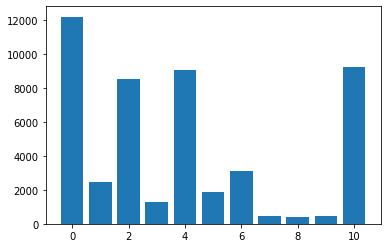

In [ ]:
pyplot.bar(range(len(lgbmr.feature_importances_)), lgbmr.feature_importances_)
pyplot.show()

From plot it is evident that along with type of item and sales price, store number and day of the week contribute to the sales. Hence we will use only these features to create models further.

In [ ]:
X = df_1[['item_id','store_id', 'd', 'weekday', 'sell_price']]
Y = df_1[['sold']]
from sklearn.model_selection import ShuffleSplit, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
print(X_train.shape, X_test.shape)

(35161257, 5) (11720420, 5)


5. Training Models

In [ ]:
lgbmr.fit(X_train, y_train) 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.3, max_depth=8,
              min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred=lgbmr.predict(X_test)

In [ ]:
print("R-squared for Train: %.2f" %lgbmr.score(X_train, y_train))
print("R-squared for Test: %.2f" %lgbmr.score(X_test, y_test))
print(lgbmr.score(X_train, y_train))

mse = mean_squared_error(y_test, y_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

R-squared for Train: 0.51
R-squared for Test: 0.50
0.5091164180627059
The mean squared error (MSE) on test set: 9.0051
The root mean squared error (RMSE) on test set: 3.0009


B. Gradient Boosting Regressor Model

In [ ]:
gbrt=GradientBoostingRegressor(n_estimators=100, subsample = 0.8, learning_rate = 0.05) 
gbrt.fit(X_train, y_train) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred=gbrt.predict(X_test)

In [ ]:
print("R-squared for Train: %.2f" %gbrt.score(X_train, y_train))
print("R-squared for Test: %.2f" %gbrt.score(X_test, y_test))
print(gbrt.score(X_train, y_train))

mse = mean_squared_error(y_test, y_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

R-squared for Train: 0.20
R-squared for Test: 0.20
0.19909977802235246
The mean squared error (MSE) on test set: 14.5662
The root mean squared error (RMSE) on test set: 3.8166


C. LSTM Model

Normalizing the input data

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))

X_train = scaler.fit_transform(X_train)

y_train = scaler.fit_transform(y_train)

X_test = scaler.fit_transform(X_test)

y_test = scaler.fit_transform(y_test)

Reshaping data

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Building LSTM model function

In [ ]:
lstm = keras.Sequential()
lstm.add(keras.layers.LSTM(
  units=50,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
lstm.add(keras.layers.Dense(units=1))
lstm.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

LSTM model fit with 2 iterations.

In [ ]:
lstm.fit(X_train, y_train, epochs = 2, batch_size = 150000)

Epoch 1/2
35161257/35161257 [==============================] - 180s 5us/step - loss: 5.8061e-05
Epoch 2/2
35161257/35161257 [==============================] - 176s 5us/step - loss: 3.0813e-05


Predictions made using LSTM model

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_pred = lstm.predict(X_test)

Denormalising data so that actual values can be compared

In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

RMSE calculation

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

The mean squared error (MSE) on test set: 17.9102
The root mean squared error (RMSE) on test set: 4.2320


6. Predictions

Required prediction for future sales are made using all 3 models and submitted to kaggle in csv format. As per kaggle score predictions made using Gradient Boosting Regressor produced better kaggle score.

Prediction method adopted is explained below. It uses Gradient Boosting model for predictions

We are taking last 28 days data for which sales data not available and making predictions.

In [ ]:
sales_pred = pd.read_csv('/content/drive/My Drive/sample_submission.csv')
sales_pred.name = 'sales_pred'

In [ ]:
df_pred = pd.melt(sales_pred, id_vars=['id'], var_name='d', value_name='sold').dropna()

In [ ]:
calendar2=calendar.tail(28)
df_pred_new = pd.merge(df_pred, calendar2, on='d', how='inner')

In [ ]:
# new data frame with split value columns 
alpha = df_pred_new["id"].str.rsplit(pat = "_", n = 3, expand = True) 
  
# making separate first name column from new data frame 
df_pred_new["item_id"]= alpha[0] 
beta2 = alpha[1]
beta3=alpha[2]
df_pred_new["store_id"] = alpha[1] + "_" + alpha[2]

In [ ]:
df_pred_new = pd.merge(df_pred_new, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [ ]:
lb_make = LabelEncoder()
df_pred_new['item_id'] = lb_make.fit_transform(df_pred_new['item_id'])
df_pred_new['store_id'] = lb_make.fit_transform(df_pred_new['store_id'])
df_pred_new['d'] = lb_make.fit_transform(df_pred_new['d'])
df_pred_new['weekday'] = lb_make.fit_transform(df_pred_new['weekday'])

df_pred_new.head()

,id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,item_id,store_id,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,2016-05-23,11617,1,3,5,2016,NaN,NaN,NaN,NaN,0,0,0,1437,0,8.382812
1,HOBBIES_1_002_CA_1_validation,0,0,2016-05-23,11617,1,3,5,2016,NaN,NaN,NaN,NaN,0,0,0,1438,0,3.970703
2,HOBBIES_1_003_CA_1_validation,0,0,2016-05-23,11617,1,3,5,2016,NaN,NaN,NaN,NaN,0,0,0,1439,0,2.970703
3,HOBBIES_1_004_CA_1_validation,0,0,2016-05-23,11617,1,3,5,2016,NaN,NaN,NaN,NaN,0,0,0,1440,0,4.640625
4,HOBBIES_1_005_CA_1_validation,0,0,2016-05-23,11617,1,3,5,2016,NaN,NaN,NaN,NaN,0,0,0,1441,0,2.880859


In [ ]:
X_prediction_new = df_pred_new[['item_id','store_id', 'd', 'weekday', 'sell_price']]
X_prediction_new = X_prediction_new.to_numpy()

In [ ]:
Final_forecast = gbrt.predict(X_prediction_new)

In [ ]:
Final_forecast = np.clip(Final_forecast, 0, 50)
Final_forecast = np.round(Final_forecast)
Final_forecast = Final_forecast.tolist()

In [ ]:
df_pred['Final_forecast'] = Final_forecast
df_predf=df_pred.pivot(index='id', columns='d', values='Final_forecast')
df_predf= df_predf.reset_index(drop= False)

In [ ]:
sales_pred1 = sales_pred['id']
df_predf = pd.merge(sales_pred1, df_predf, on=['id'], how='inner') 

In [ ]:
df_predf = df_predf.rename(columns= {'d_1942':'F1', 'd_1943' :'F2', 'd_1944':'F3', 'd_1945':'F4', 'd_1946':'F5', 'd_1947':'F6', 'd_1948':'F7', 'd_1949':'F8', 'd_1950':'F9', 'd_1951':'F10', 'd_1952':'F11', 'd_1953':'F12', 'd_1954':'F13', 'd_1955':'F14', 'd_1956':'F15', 'd_1957':'F16', 'd_1958':'F17', 'd_1959':'F18', 'd_1960':'F19', 'd_1961':'F20', 'd_1962':'F21', 'd_1963':'F22', 'd_1964':'F23', 'd_1965':'F24', 'd_1966':'F25', 'd_1967':'F26', 'd_1968':'F27', 'd_1969':'F28'})
df_predf 

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,HOBBIES_1_002_CA_1_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,HOBBIES_1_003_CA_1_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,HOBBIES_1_004_CA_1_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,HOBBIES_1_005_CA_1_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60976,FOODS_3_824_WI_3_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60977,FOODS_3_825_WI_3_evaluation,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
60978,FOODS_3_826_WI_3_evaluation,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
df_predf.to_csv('/content/drive/My Drive/prediction_gbrt.csv', encoding= 'UTF-8', index= False )